<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/07b-random_forest_backtest_ver2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Backtesting Random Forest II

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

## Outline

Follow same procedure as in 06a-random_forest_backtest except

- Multiply all features by mktvol
  - So twice as many features: original plus original*mktvol
- Use percentile (rank from 0 to 100) of return instead of (return - median) as target
- Use maxdepth=4 instead of maxdepth=3

## Read data

In [49]:
import pandas as pd

url = "https://www.dropbox.com/scl/fi/hjpebns5qv0nzh1ucl4tr/data-2023-11-13.csv?rlkey=ljnn4pf04sewolnxa96t4lpdv&dl=1"
df = pd.read_csv(url)
df.head()

,ticker,date,marketcap,pb,ret,mom,volume,volatility,roe,accruals,agr,sector,mktvol
0,AACC,2011-01-14,188.3,1.4,-0.014634,-0.184615,2.078000e+04,0.071498,-0.118239,-0.182275,0.004383,Financial Services,0.055937
1,AAI,2011-01-14,1012.1,2.0,0.002677,0.438224,2.775580e+06,0.128450,0.108073,-0.220045,0.002237,Industrials,0.055937
2,AAIC,2011-01-14,189.3,1.0,-0.010119,0.684547,3.466000e+04,0.048505,0.136967,0.108055,0.135697,Real Estate,0.055937
3,AAON,2011-01-14,479.4,4.2,0.007778,0.528685,2.817291e+05,0.044912,0.191801,-0.088557,0.011656,Basic Materials,0.055937
4,AATC,2011-01-14,63.3,1.4,-0.013960,0.008216,6.800000e+03,0.049756,0.072269,-0.008792,0.089436,Technology,0.055937


## Define model and target

In [50]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=4)

df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: x.rank(pct=True)
)

## Define predictors (features)

In [51]:
features = [
    "marketcap", 
    "pb", 
    "mom", 
    "volume", 
    "volatility", 
    "roe", 
    "accruals",
    "agr"
]
features.sort()

In [52]:
for x in features:
    df[x+"_vol"] = df[x]*df.mktvol

features += [x+"_vol" for x in features]

## Define training dates and training windows

- For this example, I am going to train once per year using the prior three years of data.
- Obviously, other choices are possible.
- The reason for not using all past data is to capture any changes in the market.

In [53]:
dates = list(df.date.unique())
dates.sort()
train_dates = dates[156::52]  # once per year starting after three years

past_dates = {}               # dates on which to train for each training date
future_dates = {}             # dates for which to predict for each training date
for date in train_dates:
    past_dates[date] = dates[(dates.index(date)-156):dates.index(date)]
    if date < train_dates[-1]:
        future_dates[date] = dates[dates.index(date):(dates.index(date)+52)]
    else:
        future_dates[date] = dates[dates.index(date):]

## Run the loop

In [54]:
new_data = None
for date in train_dates:
    past = past_dates[date]
    past = df[df.date.isin(past)]
    future = future_dates[date]
    future = df[df.date.isin(future)]
    forest.fit(X=past[features], y=past.target)
    predictions = forest.predict(X=future[features])
    predictions = pd.DataFrame(predictions)
    predictions.columns = ["predict"]
    for col in ["ticker", "date"]:
        predictions[col] = future[col].to_list()
    new_data = pd.concat((new_data, predictions))
    
df = df.merge(new_data, on=["ticker", "date"], how="inner")

In [55]:
df.tail()

,ticker,date,marketcap,pb,ret,mom,volume,volatility,roe,accruals,...,target,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,roe_vol,volatility_vol,volume_vol,predict
1010370,ZNTL,2023-11-10,1262.5,2.4,-0.449664,-0.174662,743655.8,0.086553,-0.627662,-0.179132,...,0.002790,-0.028090,0.004067,197.974602,-0.027389,0.376348,-0.098425,0.013573,116613.830640,0.483713
1010371,ZUMZ,2023-11-10,335.0,0.9,-0.069190,-0.245402,201904.4,0.053633,-0.021791,-0.020549,...,0.220982,-0.003222,-0.000772,52.531875,-0.038482,0.141130,-0.003417,0.008410,31660.945167,0.504922
1010372,ZUO,2023-11-10,1088.9,9.7,0.018065,0.080163,662494.2,0.070317,-1.501578,-1.478702,...,0.805246,-0.231878,0.001229,170.752114,0.012570,1.521072,-0.235465,0.011026,103886.753037,0.501188
1010373,ZYME,2023-11-10,504.0,1.1,-0.018843,-0.215539,435386.8,0.062766,0.446231,0.022038,...,0.537946,0.003456,0.018664,79.033029,-0.033799,0.172493,0.069974,0.009843,68273.685969,0.504806
1010374,ZYXI,2023-11-10,310.4,5.3,-0.023484,-0.356304,379338.0,0.066363,0.253785,-0.005658,...,0.500000,-0.000887,0.011390,48.674310,-0.055873,0.831101,0.039796,0.010407,59484.585863,0.504631


## Form portfolios and compute returns

In [56]:
df["rnk_long"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=False,
    method="first"
)
df["rnk_short"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=True,
    method="first"
)
longs = df[df.rnk_long<=44]
shorts = df[df.rnk_short<=44]

In [57]:
long_ret = longs.groupby("date").ret.mean()
short_ret = shorts.groupby("date").ret.mean()
print(f"mean annualized long return is {52*long_ret.mean():.2%}")
print(f"mean annualized short return is {52*short_ret.mean():.2%}")

mean annualized long return is 21.60%
mean annualized short return is -27.99%


## Try sector-neutral strategy

In [58]:
df["rnk_long"] = df.groupby(["date", "sector"], group_keys=False).predict.rank(
    ascending=False,
    method="first"
)
df["rnk_short"] = df.groupby(["date", "sector"], group_keys=False).predict.rank(
    ascending=True,
    method="first"
)
longs = df[df.rnk_long<=4]
shorts = df[df.rnk_short<=4]

In [59]:
long_neutral_ret = longs.groupby("date").ret.mean()
short_neutral_ret = shorts.groupby("date").ret.mean()
print(f"mean annualized long sector-neutral return is {52*long_neutral_ret.mean():.2%}")
print(f"mean annualized short sector-neutral return is {52*short_neutral_ret.mean():.2%}")

mean annualized long sector-neutral return is 20.04%
mean annualized short sector-neutral return is -17.89%


## Plot long-minus-short returns

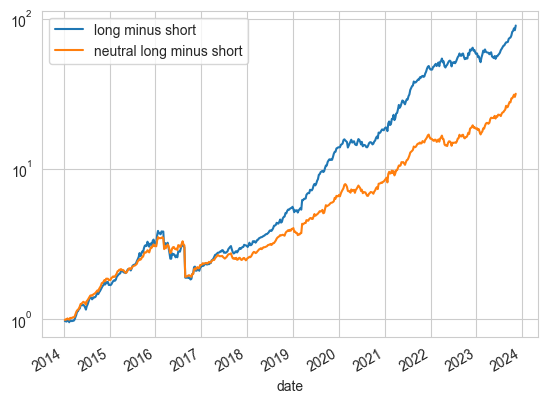

In [60]:
lms = long_ret - short_ret
lms_neutral = long_neutral_ret - short_neutral_ret

lms.index = pd.to_datetime(lms.index)
lms_neutral.index = pd.to_datetime(lms_neutral.index)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

(1+lms).cumprod().plot(logy=True, label="long minus short")
(1+lms_neutral).cumprod().plot(logy=True, label="neutral long minus short")
plt.legend()
plt.show()